## Init notebook

This is run once.

In [2]:
# To access local files, we need to mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#%%capture

# Install a local package.
!pip install captum
!pip install quantus # -e drive/MyDrive/Projects/quantus/. --user  #
#!pip install git+https://github.com/understandable-machine-intelligence-lab/Quantus.git@xai-skill-score
!pip install -e drive/MyDrive/Projects/MetaQuantus/. --user #!pip install git+https://github.com/annahedstroem/MetaQuantus.git

# Reload changes.
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.9/248.9 kB 4.8 MB/s eta 0:00:00
Obtaining file:///content/drive/MyDrive/Projects/MetaQuantus
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.5 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Running setup.py develop for metaquantus


## Preliminaries

In [1]:
import quantus
import metaquantus

In [2]:
# Set paths.
PATH_ASSETS = "/content/drive/MyDrive/Projects/MetaQuantus/assets/"

# Import local packages.
#import sys
#path = "/content/drive/MyDrive/Projects"
#sys.path.append(f'{path}/quantus')
#sys.path.append(f'{path}/MetaQuantus')
#import quantus
#import metaquantus

# Import libraries.
from IPython.display import clear_output
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import torch
import captum

try:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Using device:', torch.cuda.get_device_name(0))
    !nvidia-smi
except:
    pass

Using device: Tesla V100-SXM2-16GB
Thu Aug 24 11:02:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    51W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                     

### Code

In [3]:
"""This module holds a collection of loss functions i.e., ways to measure the loss between two inputs."""

# This file is part of Quantus.
# Quantus is free software: you can redistribute it and/or modify it under the terms of the GNU Lesser General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
# Quantus is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Lesser General Public License for more details.
# You should have received a copy of the GNU Lesser General Public License along with Quantus. If not, see <https://www.gnu.org/licenses/>.
# Quantus project URL: <https://github.com/understandable-machine-intelligence-lab/Quantus>.

import scipy
import numpy as np


def entropy(a: np.array, x: np.array, **kwargs) -> float:
    """
    Calculate entropy.

    Parameters
    ----------
    a: np.ndarray
        Array to calculate entropy on.
    x: np.ndarray
        Array to compute shape.
    kwargs: optional
            Keyword arguments.
        normalise_mse: boolean
            Indicates whether to returned a normalised MSE calculation or not.

    Returns
    -------
    float:
        A floating point of MSE.
    """

    if len(x.shape) == 1:
        newshape = np.prod(x.shape)
    else:
        newshape = np.prod(x.shape[1:])

    a = np.array(np.reshape(a, newshape), dtype=np.float64) / np.sum(np.abs(a))

    return scipy.stats.entropy(pk=a)


def gini_coeffiient(a: np.array, x: np.array, **kwargs) -> float:
    """
    Calculate Gini coefficient.

    Parameters
    ----------
    a: np.ndarray
        Array to calculate gini_coeffiient on.
    x: np.ndarray
        Array to compute shape.
    kwargs: optional
            Keyword arguments.
        normalise_mse: boolean
            Indicates whether to returned a normalised MSE calculation or not.

    Returns
    -------
    float:
        A floating point of MSE.
    """

    if len(x.shape) == 1:
        newshape = np.prod(x.shape)
    else:
        newshape = np.prod(x.shape[1:])

    a = np.array(np.reshape(a, newshape), dtype=np.float64)
    a += 0.0000001
    a = np.sort(a)
    score = (np.sum((2 * np.arange(1, a.shape[0] + 1) - a.shape[0] - 1) * a)) / (
        a.shape[0] * np.sum(a)
    )
    return score

In [82]:
"""This module contains the implementation of the Model Parameter Sensitivity metric."""

# This file is part of Quantus.
# Quantus is free software: you can redistribute it and/or modify it under the terms of the GNU Lesser General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.
# Quantus is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU Lesser General Public License for more details.
# You should have received a copy of the GNU Lesser General Public License along with Quantus. If not, see <https://www.gnu.org/licenses/>.
# Quantus project URL: <https://github.com/understandable-machine-intelligence-lab/Quantus>.

from typing import (
    Any,
    Callable,
    Dict,
    List,
    Optional,
    Tuple,
    Union,
    Collection,
    Iterable,
)
import os
import numpy as np
from tqdm.auto import tqdm
import torch

from quantus.helpers import asserts
from quantus.helpers import warn
from quantus.helpers.model.model_interface import ModelInterface
from quantus.functions.normalise_func import normalise_by_max
#from quantus.functions.scores_func import *
from quantus.metrics.base import Metric
from quantus.helpers.enums import (
    ModelType,
    DataType,
    ScoreDirection,
    EvaluationCategory,
)


class MPT_Complexity(Metric):
    """
    Implementation of the NAME by AUTHOR et. al., 2023.

    INSERT DESC.

    References:
        1) Julius Adebayo et al.: "Sanity Checks for Saliency Maps." NeurIPS (2018): 9525-9536.

    Attributes:
        -  _name: The name of the metric.
        - _data_applicability: The data types that the metric implementation currently supports.
        - _models: The model types that this metric can work with.
        - score_direction: How to interpret the scores, whether higher/ lower values are considered better.
        - evaluation_category: What property/ explanation quality that this metric measures.
    """

    name = "Model Parameter Randomisation"
    data_applicability = {DataType.IMAGE, DataType.TIMESERIES, DataType.TABULAR}
    model_applicability = {ModelType.TORCH, ModelType.TF}
    score_direction = ScoreDirection.LOWER
    evaluation_category = EvaluationCategory.RANDOMISATION

    def __init__(
        self,
        quality_func: Optional[Callable] = None,
        layer_order: str = "bottom_up",
        nr_samples: int = 10,
        seed: int = 42,
        return_sample_complexity: bool = False,
        abs: bool = True,
        normalise: bool = True,
        normalise_func: Optional[Callable[[np.ndarray], np.ndarray]] = None,
        normalise_func_kwargs: Optional[Dict[str, Any]] = None,
        return_aggregate: bool = False,
        aggregate_func: Callable = None,
        default_plot_func: Optional[Callable] = None,
        disable_warnings: bool = False,
        display_progressbar: bool = False,
        **kwargs,
    ):
        """
        Parameters
        ----------
        similarity_func: callable
            Similarity function applied to compare input and perturbed input, default=correlation_spearman.
        layer_order: string
            Indicated whether the model is randomized cascadingly or independently.
            Set order=top_down for cascading randomization, set order=independent for independent randomization,
            default="independent".
        seed: integer
            Seed used for the random generator, default=42.
        return_sample_complexity: boolean
            Indicates whether return one float per sample, representing the average
            correlation coefficient across the layers for that sample.
        abs: boolean
            Indicates whether absolute operation is applied on the attribution, default=True.
        normalise: boolean
            Indicates whether normalise operation is applied on the attribution, default=True.
        normalise_func: callable
            Attribution normalisation function applied in case normalise=True.
            If normalise_func=None, the default value is used, default=normalise_by_max.
        normalise_func_kwargs: dict
            Keyword arguments to be passed to normalise_func on call, default={}.
        return_aggregate: boolean
            Indicates if an aggregated score should be computed over all instances.
        aggregate_func: callable
            Callable that aggregates the scores given an evaluation call.
        default_plot_func: callable
            Callable that plots the metrics result.
        disable_warnings: boolean
            Indicates whether the warnings are printed, default=False.
        display_progressbar: boolean
            Indicates whether a tqdm-progress-bar is printed, default=False.
        kwargs: optional
            Keyword arguments.
        """
        if normalise_func is None:
            normalise_func = normalise_by_max

        super().__init__(
            abs=abs,
            normalise=normalise,
            normalise_func=normalise_func,
            normalise_func_kwargs=normalise_func_kwargs,
            return_aggregate=return_aggregate,
            aggregate_func=aggregate_func,
            default_plot_func=default_plot_func,
            display_progressbar=display_progressbar,
            disable_warnings=disable_warnings,
            **kwargs,
        )

        # Set seed for reproducibility
        if seed is not None:
            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            os.environ['PYTHONHASHSEED'] = str(seed)

            #torch.backends.cudnn.benchmark = False
            #torch.backends.cudnn.deterministic = True
            #torch.backends.cudnn.enabled = False

        # Save metric-specific attributes.
        if quality_func is None:
            quality_func = gini_coeffiient

        self.quality_func = quality_func
        self.layer_order = layer_order
        self.nr_samples = nr_samples
        self.return_sample_complexity = return_sample_complexity

        # Results are returned/saved as a dictionary not like in the super-class as a list.
        self.scores_expl_random = np.array([])
        self.scores_expl_constant = np.array([])
        self.scores_expl_model_randomised = {}

        # Asserts and warnings.
        asserts.assert_layer_order(layer_order=self.layer_order)
        if not self.disable_warnings:
            warn.warn_parameterisation(
                metric_name=self.__class__.__name__,
                sensitive_params=(
                    "similarity metric 'similarity_func' and the order of "
                    "the layer randomisation 'layer_order'"
                ),
                citation=(
                    "Adebayo, J., Gilmer, J., Muelly, M., Goodfellow, I., Hardt, M., and Kim, B. "
                    "'Sanity Checks for Saliency Maps.' arXiv preprint,"
                    " arXiv:1810.073292v3 (2018)"
                ),
            )

    def __call__(
        self,
        model,
        x_batch: np.array,
        y_batch: np.array,
        a_batch: Optional[np.ndarray] = None,
        s_batch: Optional[np.ndarray] = None,
        channel_first: Optional[bool] = None,
        explain_func: Optional[Callable] = None,
        explain_func_kwargs: Optional[Dict] = None,
        model_predict_kwargs: Optional[Dict] = None,
        softmax: Optional[bool] = False,
        device: Optional[str] = None,
        batch_size: int = 64,
        custom_batch: Optional[Any] = None,
        attributions_path: str = None,
        **kwargs,
    ) -> Union[List[float], float, Dict[str, List[float]], Collection[Any]]:
        """
        This implementation represents the main logic of the metric and makes the class object callable.
        It completes instance-wise evaluation of explanations (a_batch) with respect to input data (x_batch),
        output labels (y_batch) and a torch or tensorflow model (model).

        Calls general_preprocess() with all relevant arguments, calls
        () on each instance, and saves results to evaluation_scores.
        Calls custom_postprocess() afterwards. Finally returns evaluation_scores.

        The content of evaluation_scores will be appended to all_evaluation_scores (list) at the end of
        the evaluation call.

        Parameters
        ----------
        model: torch.nn.Module, tf.keras.Model
            A torch or tensorflow model that is subject to explanation.
        x_batch: np.ndarray
            A np.ndarray which contains the input data that are explained.
        y_batch: np.ndarray
            A np.ndarray which contains the output labels that are explained.
        a_batch: np.ndarray, optional
            A np.ndarray which contains pre-computed attributions i.e., explanations.
        s_batch: np.ndarray, optional
            A np.ndarray which contains segmentation masks that matches the input.
        channel_first: boolean, optional
            Indicates of the image dimensions are channel first, or channel last.
            Inferred from the input shape if None.
        explain_func: callable
            Callable generating attributions.
        explain_func_kwargs: dict, optional
            Keyword arguments to be passed to explain_func on call.
        model_predict_kwargs: dict, optional
            Keyword arguments to be passed to the model's predict method.
        softmax: boolean
            Indicates whether to use softmax probabilities or logits in model prediction.
            This is used for this __call__ only and won't be saved as attribute. If None, self.softmax is used.
        device: string
            Indicated the device on which a torch.Tensor is or will be allocated: "cpu" or "gpu".
        kwargs: optional
            Keyword arguments.

        Returns
        -------
        evaluation_scores: list
            a list of Any with the evaluation scores of the concerned batch.

        Examples:
        --------
            # Minimal imports.
            >> import quantus
            >> from quantus import LeNet
            >> import torch

            # Enable GPU.
            >> device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

            # Load a pre-trained LeNet classification model (architecture at quantus/helpers/models).
            >> model = LeNet()
            >> model.load_state_dict(torch.load("tutorials/assets/pytests/mnist_model"))

            # Load MNIST datasets and make loaders.
            >> test_set = torchvision.datasets.MNIST(root='./sample_data', download=True)
            >> test_loader = torch.utils.data.DataLoader(test_set, batch_size=24)

            # Load a batch of inputs and outputs to use for XAI evaluation.
            >> x_batch, y_batch = iter(test_loader).next()
            >> x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

            # Generate Saliency attributions of the test set batch of the test set.
            >> a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1)
            >> a_batch_saliency = a_batch_saliency.cpu().numpy()

            # Initialise the metric and evaluate explanations by calling the metric instance.
            >> metric = Metric(abs=True, normalise=False)
            >> scores = metric(model=model, x_batch=x_batch, y_batch=y_batch, a_batch=a_batch_saliency}
        """

        # Run deprecation warnings.
        warn.deprecation_warnings(kwargs)
        warn.check_kwargs(kwargs)

        data = self.general_preprocess(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            a_batch=a_batch,
            s_batch=s_batch,
            custom_batch=None,
            channel_first=channel_first,
            explain_func=explain_func,
            explain_func_kwargs=explain_func_kwargs,
            model_predict_kwargs=model_predict_kwargs,
            softmax=softmax,
            device=device,
        )

        # Initialise arrays.
        self.scores_expl_random = np.zeros((self.nr_samples))
        self.scores_expl_constant = np.zeros((self.nr_samples))
        self.scores_expl_model_randomised = {} # np.zeros((self.n_layers, a_batch.shape[0]))

        # Get model and data.
        model = data["model"]
        x_batch = data["x_batch"]
        y_batch = data["y_batch"]
        a_batch = data["a_batch"]

        # Get number of iterations from number of layers.
        n_layers = len(list(model.get_random_layer_generator(order=self.layer_order)))
        model_iterator = tqdm(
            model.get_random_layer_generator(order=self.layer_order),
            total=n_layers,
            disable=not self.display_progressbar,
        )

        # Compute the scores_expl_model_randomised of a uniformly sampled explanation.
        a_batch_random = np.random.rand(*(self.nr_samples, *a_batch.shape[1:]))
        for a_ix, a_random in enumerate(a_batch_random):
            self.scores_expl_random[a_ix] = self.quality_func(a=a_random, x=x_batch[0])

        # Compute the scores_expl_model_randomised of a uniformly sampled explanation.
        #a_batch_constant = np.zeros_like(*(self.nr_samples, *a_batch.shape[1:]))
        #for a_ix, a_batch_const in enumerate(a_batch_constant):
        #    self.scores_expl_constant[a_ix] = self.quality_func(a=a_batch_const, x=x_batch[0])

        for l_ix, (layer_name, random_layer_model) in enumerate(model_iterator):

            if l_ix == 0:

                # Generate an explanation with perturbed model.
                a_batch_original = self.explain_func(
                    model=model.get_model(),
                    inputs=x_batch,
                    targets=y_batch,
                    **self.explain_func_kwargs,
                )

                # Normalise with specified keyword arguments if requested.
                if self.normalise:
                    a_batch_original = self.normalise_func(
                        a=a_batch_original,
                        normalise_axes=list(range(np.ndim(data["a_batch"])))[1:],
                        **self.normalise_func_kwargs,
                    )

                # Take absolute if requested.
                if self.abs:
                    a_batch_original = np.abs(a_batch_original)

                for a_ix, a_ori in enumerate(a_batch_original):
                    self.scores_expl_model_randomised["orig"] = self.quality_func(a=np.abs(a_ori), x=x_batch[0])

            scores_expl_model_randomised_scores = [None for _ in x_batch]

            # Generate an explanation with perturbed model.
            a_batch_perturbed = self.explain_func(
                model=random_layer_model,
                inputs=x_batch,
                targets=y_batch,
                **self.explain_func_kwargs,
            )

            # Get id for storage
            if attributions_path is not None:
                savepath = os.path.join(attributions_path, f"{l_ix}-{layer_name}")
                os.makedirs(savepath, exist_ok=True)
                last_id = 0
                for fname in os.listdir(savepath):
                    if "original_attribution_" in fname:
                        id = int(fname.split("original_attribution_")[1].split(".")[0]) > last_id
                        if id > last_id:
                            last_id = id

            batch_iterator = enumerate(zip(a_batch, a_batch_perturbed))
            for instance_id, (a_instance, a_instance_perturbed) in batch_iterator:
                score = self.evaluate_instance(
                    model=random_layer_model,
                    x=x_batch[0],
                    y=None,
                    s=None,
                    a=a_instance,
                    a_perturbed=a_instance_perturbed,
                )
                scores_expl_model_randomised_scores.append(score)

                if attributions_path is not None:
                    np.save(os.path.join(savepath, f"input_{last_id+instance_id}.npy"), x_batch[instance_id])
                    np.save(os.path.join(savepath, f"original_attribution_{last_id+instance_id}.npy"), a_instance)
                    np.save(os.path.join(savepath, f"perturbed_attribution_{last_id+instance_id}.npy"), a_instance_perturbed)


            # Save scores_expl_model_randomised scores in a result dictionary.
            self.scores_expl_model_randomised[layer_name] = scores_expl_model_randomised_scores

        # Call post-processing.
        self.custom_postprocess(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            a_batch=a_batch,
            s_batch=s_batch,
        )

        if self.return_sample_complexity:
            self.evaluation_scores = self.recompute_scores_per_sample()

        if self.return_aggregate:
            assert self.return_sample_complexity, (
                "You must set 'return_sample_complexity' to True in order to compute the aggregate."
            )
            self.scores_expl_model_randomised = [self.aggregate_func(self.scores_expl_model_randomised)]

        self.all_evaluation_scores.append(self.scores_expl_model_randomised)

        return self.evaluation_scores

    def evaluate_instance(
        self,
        model: ModelInterface,
        x: Optional[np.ndarray],
        y: Optional[np.ndarray],
        a: Optional[np.ndarray],
        s: Optional[np.ndarray],
        a_perturbed: Optional[np.ndarray] = None,
    ) -> float:
        """
        Evaluate instance gets model and data for a single instance as input and returns the evaluation result.

        Parameters
        ----------
        i: integer
            The evaluation instance.
        model: ModelInterface
            A ModelInteface that is subject to explanation.
        x: np.ndarray
            The input to be evaluated on an instance-basis.
        y: np.ndarray
            The output to be evaluated on an instance-basis.
        a: np.ndarray
            The explanation to be evaluated on an instance-basis.
        s: np.ndarray
            The segmentation to be evaluated on an instance-basis.
        a_perturbed: np.ndarray
            The perturbed attributions.

        Returns
        -------
        float
            The evaluation results.
        """
        if self.normalise:
            a_perturbed = self.normalise_func(a_perturbed, **self.normalise_func_kwargs)

        if self.abs:
            a_perturbed = np.abs(a_perturbed)

        # Compute distance measure.
        return self.quality_func(a=a_perturbed, x=x)

    def custom_preprocess(
        self,
        model: ModelInterface,
        x_batch: np.ndarray,
        y_batch: Optional[np.ndarray],
        a_batch: Optional[np.ndarray],
        s_batch: np.ndarray,
        custom_batch: Optional[np.ndarray],
    ) -> None:
        """
        Implementation of custom_preprocess_batch.

        Parameters
        ----------
        model: torch.nn.Module, tf.keras.Model
            A torch or tensorflow model e.g., torchvision.models that is subject to explanation.
        x_batch: np.ndarray
            A np.ndarray which contains the input data that are explained.
        y_batch: np.ndarray
            A np.ndarray which contains the output labels that are explained.
        a_batch: np.ndarray, optional
            A np.ndarray which contains pre-computed attributions i.e., explanations.
        s_batch: np.ndarray, optional
            A np.ndarray which contains segmentation masks that matches the input.
        custom_batch: any
            Gives flexibility ot the user to use for evaluation, can hold any variable.

        Returns
        -------
        None
        """
        # Additional explain_func assert, as the one in general_preprocess()
        # won't be executed when a_batch != None.
        asserts.assert_explain_func(explain_func=self.explain_func)

    def recompute_scores_per_sample(
        self,
    ) -> Union[List[List[Any]], Dict[int, List[Any]]]:

        assert isinstance(self.evaluation_scores, dict), (
            "To compute the average correlation coefficient per sample for "
            "Model Parameter Randomisation Test, 'last_result' "
            "must be of type dict."
        )
        layer_length = len(
            self.evaluation_scores[list(self.evaluation_scores.keys())[0]]
        )
        results: Dict[int, list] = {sample: [] for sample in range(layer_length)}

        for sample in results:
            for layer in self.evaluation_scores:
                results[sample].append(float(self.evaluation_scores[layer][sample]))
            results[sample] = np.mean(results[sample])

        corr_coeffs = list(results.values())

        return corr_coeffs


## Experiment



In [83]:
from metaquantus import setup_dataset_models, setup_xai_settings

In [115]:
import torchvision

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


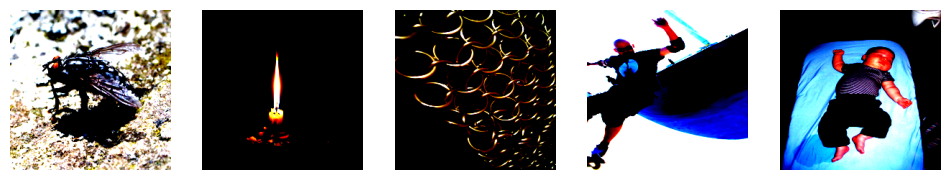

In [117]:
# Load data.
dataset_name = "ImageNet"
nr_test_samples = 100

# Get input, outputs settings.
dataset_settings, model_name = setup_dataset_models(
    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
)
estimator_kwargs = dataset_settings[dataset_name]["estimator_kwargs"]

model = dataset_settings[dataset_name]["models"][model_name].eval()
model = torchvision.models.vgg16().eval()
x_batch = dataset_settings[dataset_name]["x_batch"][:nr_test_samples]
y_batch = dataset_settings[dataset_name]["y_batch"][:nr_test_samples]
s_batch = dataset_settings[dataset_name]["s_batch"][:nr_test_samples]

img_size = x_batch.shape[2]
nr_channels = x_batch.shape[1]
nr_classes = estimator_kwargs["num_classes"]

# Plot the data!
fix, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5):
    ax[i].imshow(np.moveaxis(x_batch[i], 0, -1).reshape(img_size, img_size, nr_channels))
    ax[i].axis("off")
plt.show()

In [97]:
quantus.AVAILABLE_XAI_METHODS_CAPTUM

['GradientShap',
 'IntegratedGradients',
 'DeepLift',
 'DeepLiftShap',
 'InputXGradient',
 'Saliency',
 'FeatureAblation',
 'Deconvolution',
 'FeaturePermutation',
 'Lime',
 'KernelShap',
 'LRP',
 'Gradient',
 'Occlusion',
 'LayerGradCam',
 'GuidedGradCam',
 'LayerConductance',
 'LayerActivation',
 'InternalInfluence',
 'LayerGradientXActivation',
 'Control Var. Sobel Filter',
 'Control Var. Constant',
 'Control Var. Random Uniform']

In [123]:
# Load explanation methods.
xai_setting = ["Gradient", "Saliency", "IntegratedGradients"]#, "Control Var. Constant"]
 # "LayerGradCam",
xai_methods = setup_xai_settings(
    xai_settings=xai_setting,
    gc_layer=dataset_settings[dataset_name]["gc_layers"][model_name],
    img_size=estimator_kwargs["img_size"],
    nr_channels=estimator_kwargs["nr_channels"],
)
#xai_methods["LRP"] = {}
#xai_methods["Lime"] = {}
#xai_methods["InputXGradient"] = {}
#xai_methods["Occlusion"] = {}
xai_methods["KernelShap"] = {}
xai_methods

{'Gradient': {}, 'Saliency': {}, 'IntegratedGradients': {}, 'KernelShap': {}}

In [ ]:
scores = {}
nr_samples = 10

for xai_method, xai_method_kwargs in xai_methods.items():

    scores[xai_method] = {}
    #model = dataset_settings[dataset_name]["models"][model_name].eval()
    model = torchvision.models.vgg16().eval()

    # Return local MPT_Complexity estimate scores in an one-liner - by calling the metric instance.
    metric = MPT_Complexity(
            layer_order="bottom_up",
            return_sample_complexity=False,
            quality_func=gini_coeffiient,
            nr_samples=nr_samples,
            abs=True,
            normalise=False,
            #normalise_func=quantus.normalise_by_max,
            return_aggregate=False,
            disable_warnings=True,
        )

    _ = metric(model=model,
    x_batch=x_batch[:nr_samples],
    y_batch=y_batch[:nr_samples],
    a_batch=None,
    device=device,
    explain_func=quantus.explain,
    explain_func_kwargs={**{"method": xai_method}, **xai_method_kwargs})

    print(f"{xai_method} done")

    # Results are returned/saved as a dictionary not like in the super-class as a list.
    scores[xai_method]["scores_expl_random"] = metric.scores_expl_random
    scores[xai_method]["scores_expl_constant"] = metric.scores_expl_constant
    scores[xai_method]["scores_expl_model_randomised"] = metric.scores_expl_model_randomised

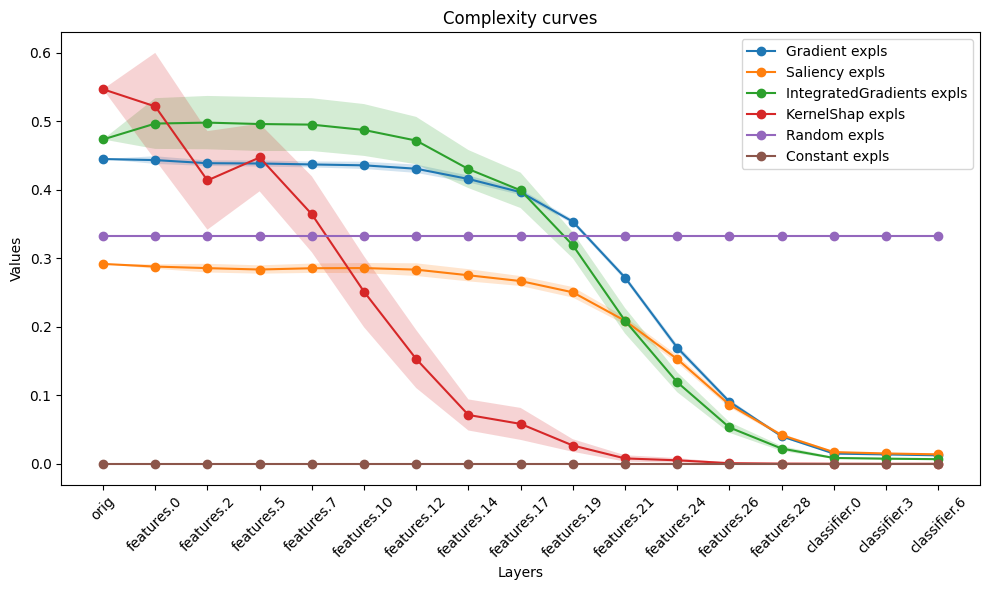

In [125]:
def replace_none(x):
    return x if x is not None else np.nan

plt.figure(figsize=(10, 6))

for method, data in scores.items():
    means = []
    stds = []
    layer_names = []
    for layer, values in data["scores_expl_model_randomised"].items():
        layer_names.append(layer)
        values = np.vectorize(replace_none)(values)
        means.append(np.nanmean(values))
        stds.append(np.nanstd(values))

    # Plot!
    plt.plot(layer_names, means, 'o-', label=method + " expls")
    plt.fill_between(layer_names, np.array(means) + np.array(stds), np.array(means) - np.array(stds), alpha=0.2)

# Plot!
scores_random = np.vectorize(replace_none)(scores[xai_method]["scores_expl_random"])
scores_random_means = np.full(len(layer_names), np.nanmean(scores_random))
scores_random_stds = np.full(len(layer_names), np.nanstd(scores_random))
plt.plot(layer_names, scores_random_means, 'o-', label="Random" + " expls")
plt.fill_between(layer_names, scores_random_means + scores_random_stds, scores_random_means - scores_random_stds, alpha=0.2)

# Plot!
scores_random = np.vectorize(replace_none)(scores[xai_method]["scores_expl_constant"])
scores_random_means = np.full(len(layer_names), np.nanmean(scores_random))
scores_random_stds = np.full(len(layer_names), np.nanstd(scores_random))
plt.plot(layer_names, scores_random_means, 'o-', label="Constant" + " expls")
plt.fill_between(layer_names, scores_random_means + scores_random_stds, scores_random_means - scores_random_stds, alpha=0.2)

plt.xticks(rotation=45)
plt.xlabel('Layers')
plt.ylabel('Values')
plt.title(f'Complexity curves')
plt.legend()
plt.tight_layout()
plt.show()

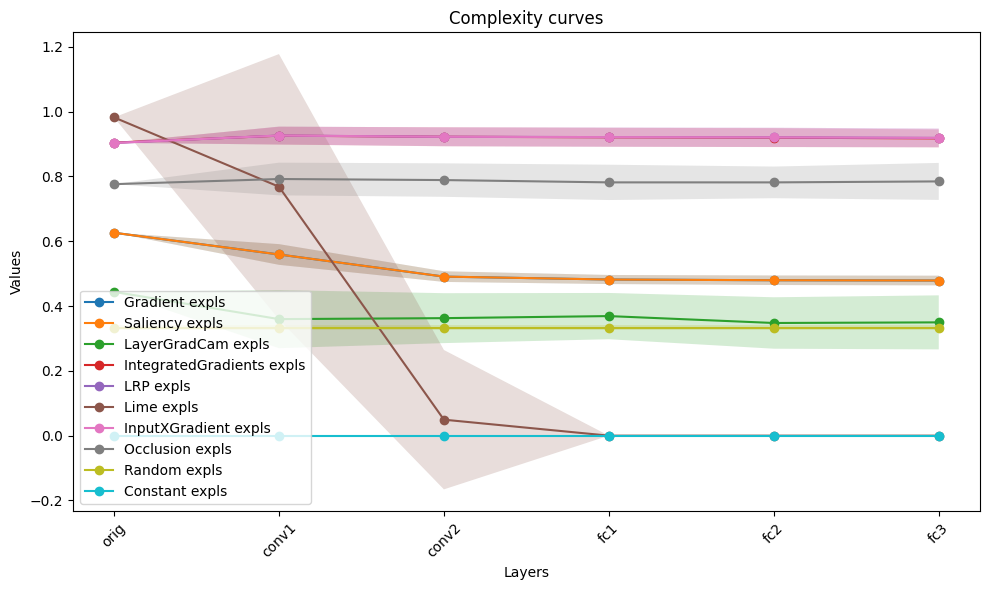

In [114]:
def replace_none(x):
    return x if x is not None else np.nan

plt.figure(figsize=(10, 6))

for method, data in scores.items():
    means = []
    stds = []
    layer_names = []
    for layer, values in data["scores_expl_model_randomised"].items():
        layer_names.append(layer)
        values = np.vectorize(replace_none)(values)
        means.append(np.nanmean(values))
        stds.append(np.nanstd(values))

    # Plot!
    plt.plot(layer_names, means, 'o-', label=method + " expls")
    plt.fill_between(layer_names, np.array(means) + np.array(stds), np.array(means) - np.array(stds), alpha=0.2)

# Plot!
scores_random = np.vectorize(replace_none)(scores[xai_method]["scores_expl_random"])
scores_random_means = np.full(len(layer_names), np.nanmean(scores_random))
scores_random_stds = np.full(len(layer_names), np.nanstd(scores_random))
plt.plot(layer_names, scores_random_means, 'o-', label="Random" + " expls")
plt.fill_between(layer_names, scores_random_means + scores_random_stds, scores_random_means - scores_random_stds, alpha=0.2)

# Plot!
scores_random = np.vectorize(replace_none)(scores[xai_method]["scores_expl_constant"])
scores_random_means = np.full(len(layer_names), np.nanmean(scores_random))
scores_random_stds = np.full(len(layer_names), np.nanstd(scores_random))
plt.plot(layer_names, scores_random_means, 'o-', label="Constant" + " expls")
plt.fill_between(layer_names, scores_random_means + scores_random_stds, scores_random_means - scores_random_stds, alpha=0.2)

plt.xticks(rotation=45)
plt.xlabel('Layers')
plt.ylabel('Values')
plt.title(f'Complexity curves')
plt.legend()
plt.tight_layout()
plt.show()